# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

C:\Users\kkliv\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

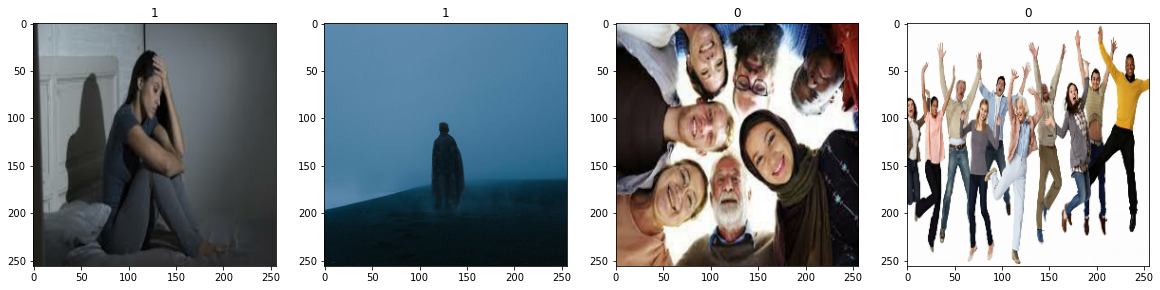

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          [2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          [2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          ...,
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02],
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02],
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02]],
 
         [[2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          [2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          [2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          ...,
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02],
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02],
          [2.35294122e-02, 2.35294122e-02, 2.35294122e-02]],
 
         [[2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          [2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          [2.74509806e-02, 1.96078438e-02, 2.35294122e-02],
          ...,
          [2.35294122e-02, 2.35294122e-02, 2.3529

# 5. Split Data

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size

7

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [18]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 46s 5s/step - loss: 2.5819 - accuracy: 0.5179 - val_loss: 0.6963 - val_accuracy: 0.4688
Epoch 2/20
7/7 [==============================] - 29s 4s/step - loss: 0.6874 - accuracy: 0.5268 - val_loss: 0.6735 - val_accuracy: 0.6250
Epoch 3/20
7/7 [==============================] - 28s 4s/step - loss: 0.6624 - accuracy: 0.5223 - val_loss: 0.6332 - val_accuracy: 0.7344
Epoch 4/20
7/7 [==============================] - 29s 4s/step - loss: 0.6047 - accuracy: 0.6696 - val_loss: 0.5964 - val_accuracy: 0.7188
Epoch 5/20
7/7 [==============================] - 30s 4s/step - loss: 0.5378 - accuracy: 0.7857 - val_loss: 0.8325 - val_accuracy: 0.5625
Epoch 6/20
7/7 [==============================] - 34s 5s/step - loss: 0.5738 - accuracy: 0.7188 - val_loss: 0.5244 - val_accuracy: 0.7031
Epoch 7/20
7/7 [==============================] - 35s 5s/step - loss: 0.5180 - accuracy: 0.7411 - val_loss: 0.5032 - val_accuracy: 0.8125
Epoch 8/20
7/7 [==================

# 8. Plot Performance

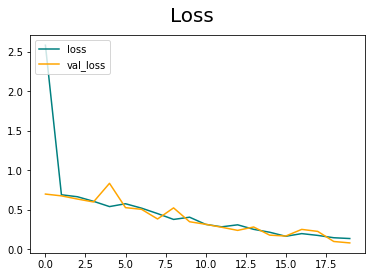

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

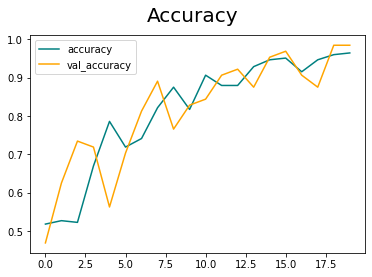

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 4s 4s/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

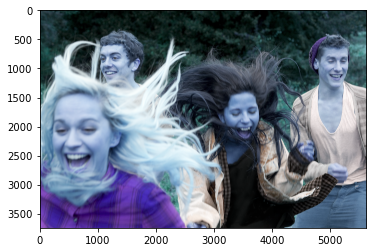

In [36]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

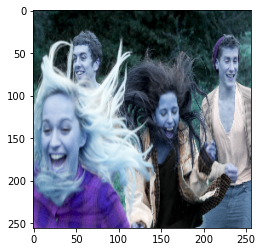

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 6s 6s/step


In [39]:
yhat

array([[0.72495174]], dtype=float32)

In [40]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
#model.save(os.path.join('models','imageclassifier.h5'))

C:\Users\kkliv\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
#model.save(os.path.join('models','imageclassifier.keras'))

In [47]:
model.save('imageclassifier.keras')

In [48]:
new_model = load_model('imageclassifier.keras')

In [49]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 1s 866ms/step


array([[0.72495174]], dtype=float32)

In [52]:
pip install --upgrade jinja2

Note: you may need to restart the kernel to use updated packages.


In [51]:
from markupsafe import Markup
Markup()


Markup('')

In [53]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.
